O objetivo deste trabalho é comparar duas abordagens para calibração de câmera: o Toolbox de calibração e uma implementação em Python.

A calibração visa determinar os parâmetros intrínsecos e extrínsecos da câmera. Os parâmetros intrínsecos incluem:

    1. Distância focal (Focal Length)
    2. Tamanho do pixel (sx, sy)
    3. Coeficientes de distorção (k1, k2)
    4. Ponto principal (cx, cy)

Os parâmetros extrínsecos descrevem a posição e orientação da câmera:

    1. Matriz de rotação

    2. Matriz de translação

# Primeiro metodo - Octave Toolbox
:



Essa foi a fotografia utilizada. Cada quadradinho tem 26.5mm x 26.5mm 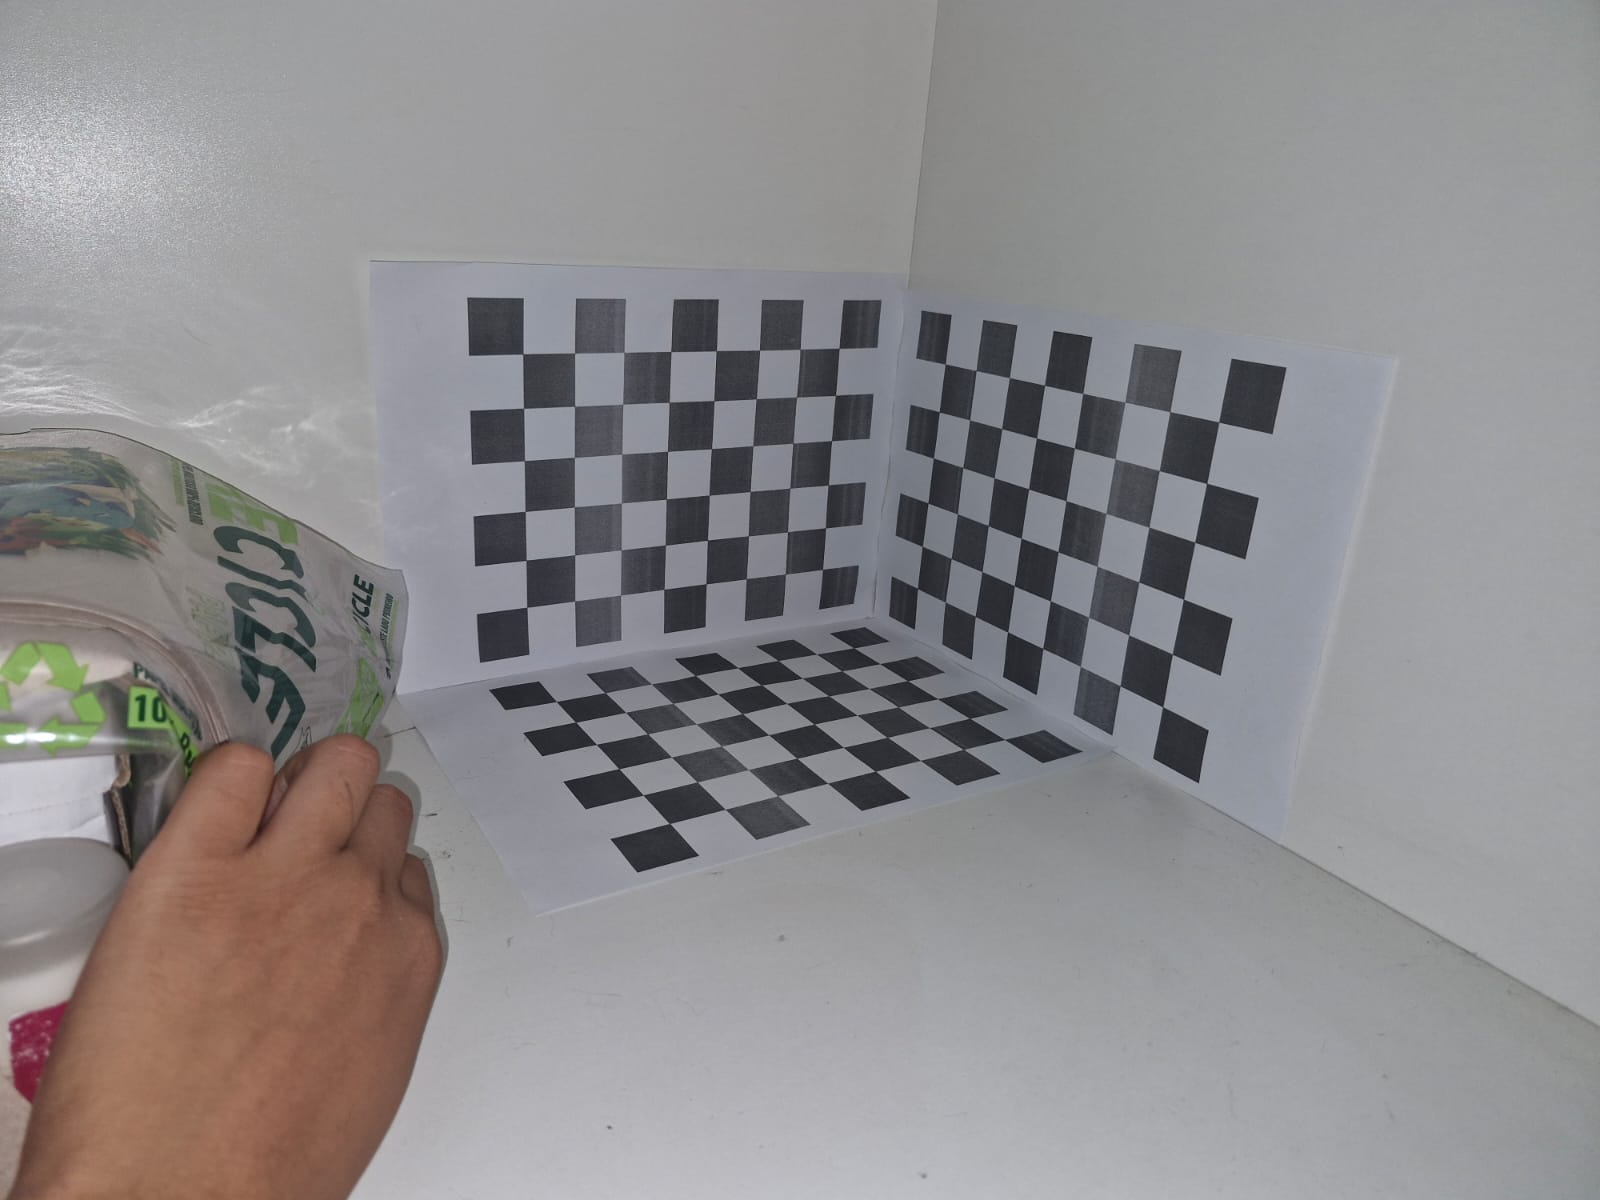

Utilizamos uma configuração tridimensional para evitar problemas de colinearidade e fornecer ao algoritmo de calibração variações reais em todos os eixos espaciais (X, Y e Z). Isso melhora a estimativa da geometria da cena e aumenta a precisão tanto dos parâmetros intrínsecos quanto dos extrínsecos da câmera.

Com isso em mente, podemos comecar o processo de calibracao utilizando o Octave Toolbox, que consiste em:
1. Selecionar as imagem.
2. Denotar os eixos de coordenadas nas imagens.
3. Calculo dos parametros da camera.


Criei 3 imagens iguais, entao selecionei os eixos x, y nas 3 e inseri o tamanho dos quadrados:


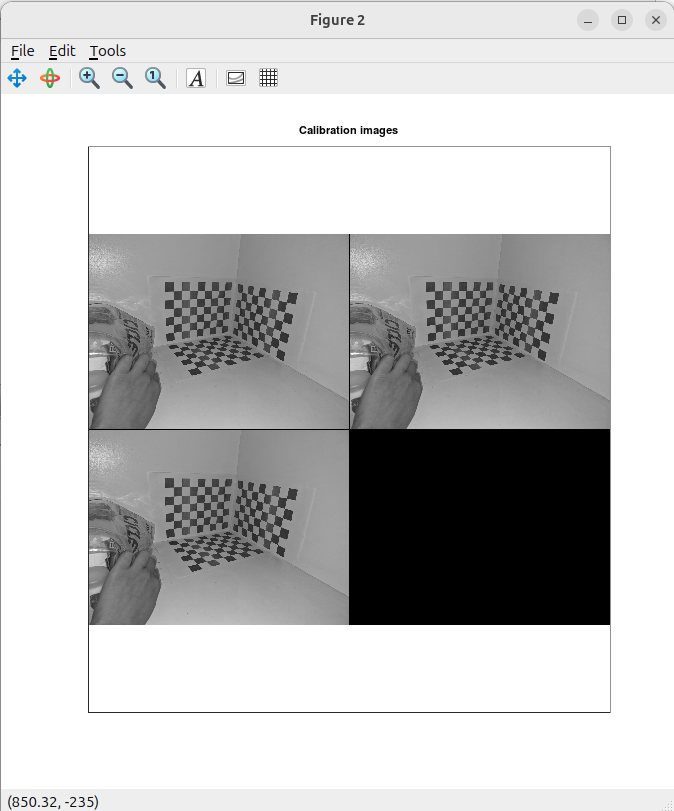 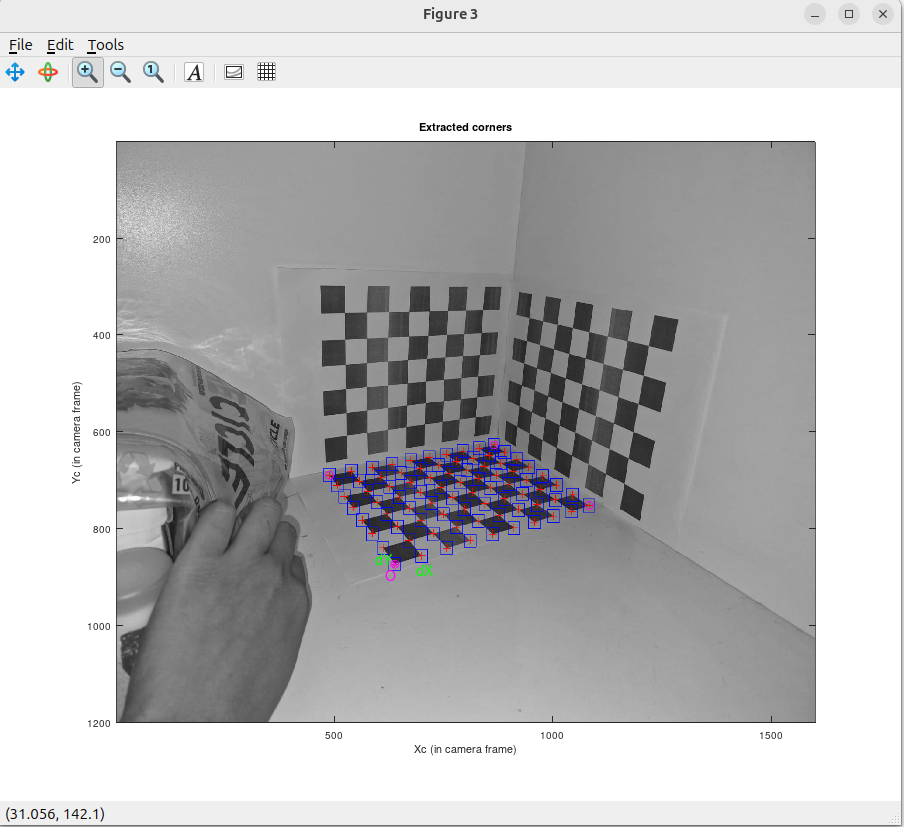
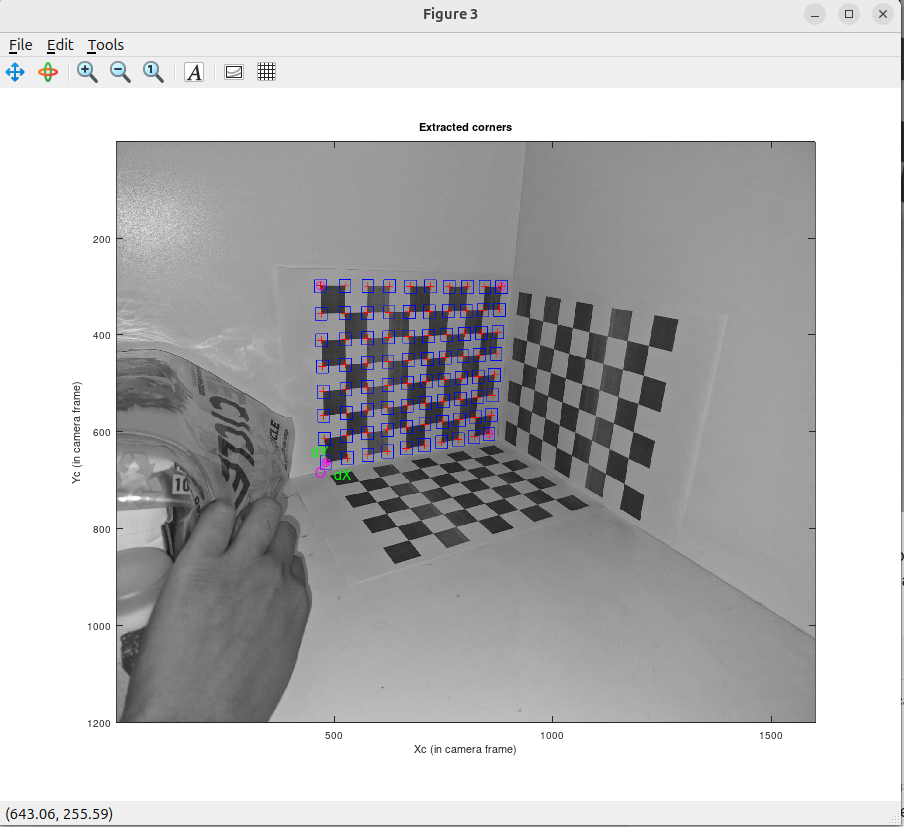
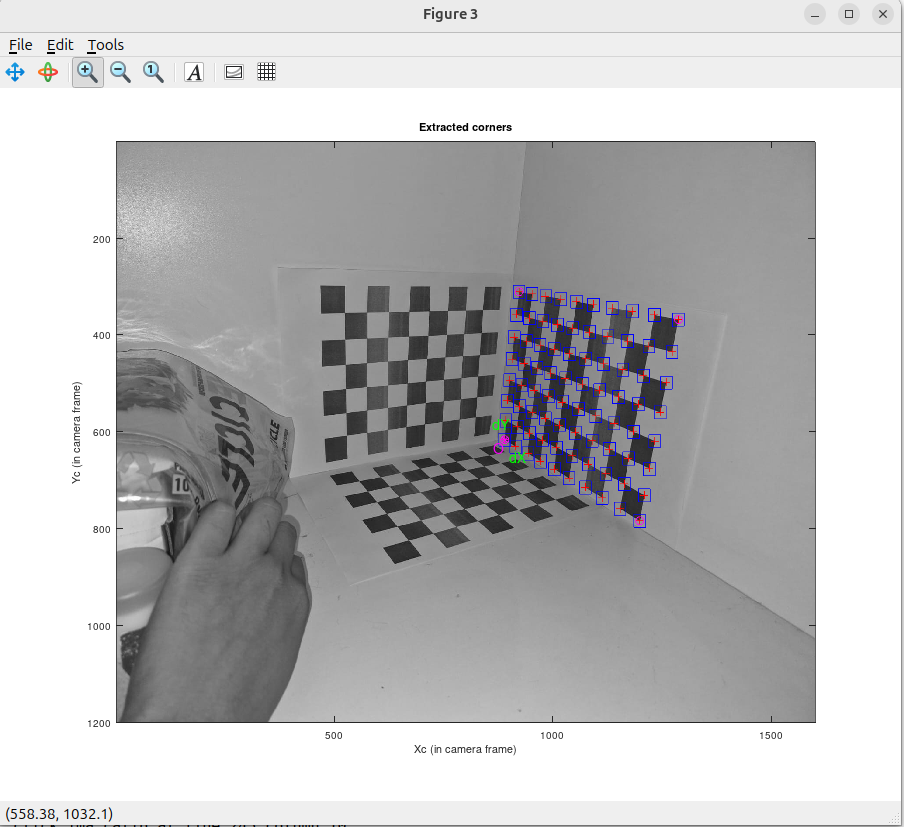

Apos isso, o software calcula os parametros intrinsecos da camera:

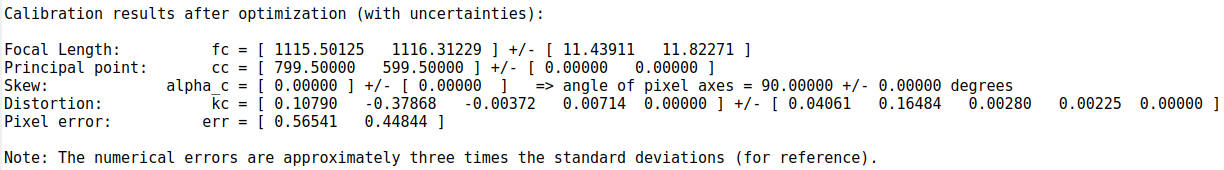

Resultado em matriz:

\[
\begin{array}{c@{\hspace{1.5cm}}c}
\textbf{Matriz Intrínseca} &  \\[1ex]
\begin{bmatrix}
1115.59 & 0 & 799.60 \\
0 & 1116.31 & 599.59 \\
0 & 0 & 1
\end{bmatrix}
\end{array}
\]


# Segundo metodo - Utilizando SVD

Peguei a foto, tracei os eixos xyz, entao selecionei alguns pontos conforme a seguinte imagem:

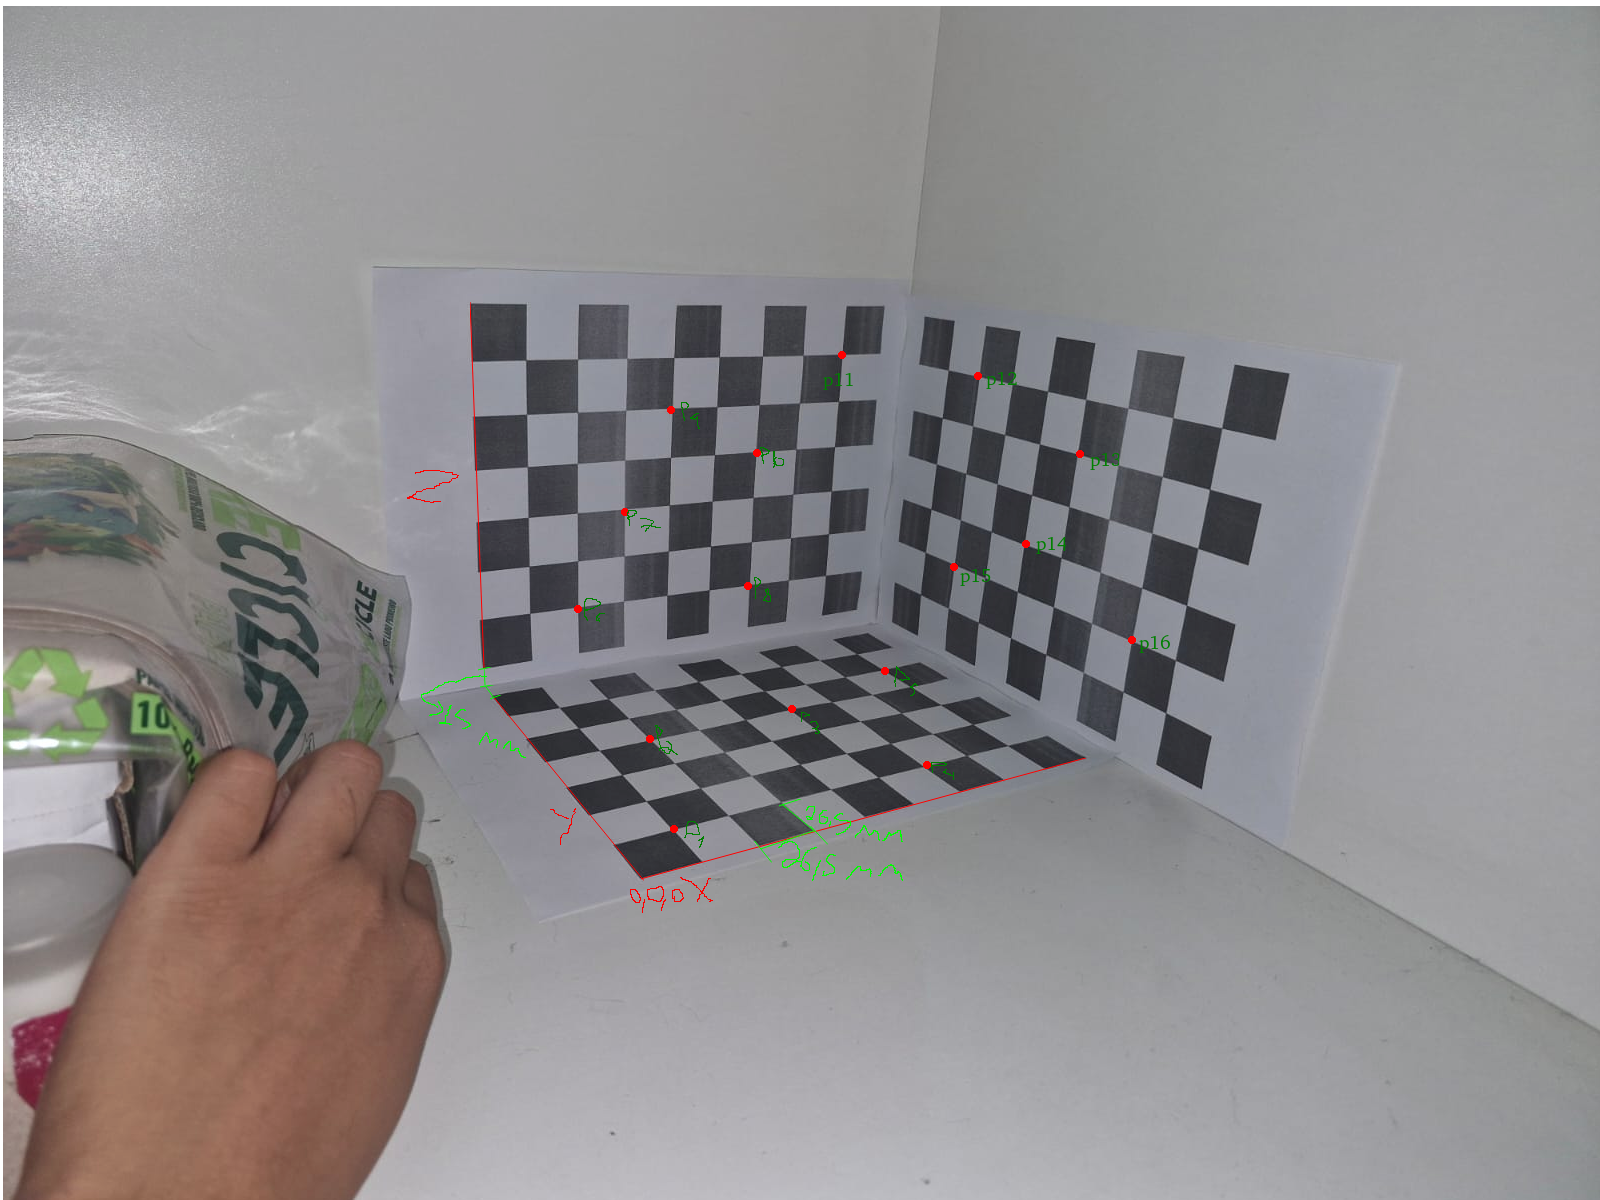

In [ ]:
from IPython.display import Image, display

display(Image(filename='eixos_pontos.png'))


📦 1. Imports

In [ ]:
import numpy as np
import scipy.linalg


2. Dados 3D e escala

In [ ]:
# Coordenadas em quadrados
q_points = np.array([
    [1, 1, 0],
    [2, 4, 0],
    [5, 4, 0],
    [6, 1, 0],
    [8, 5, 0],
    [2, 7, 1],
    [3, 7, 3],
    [6, 7, 1],
    [4, 7, 5],
    [6, 7, 4],
    [8, 7, 6],
    [9, 5, 6],
    [9, 2, 5],
    [9, 3, 3],
    [9, 5, 2],
    [9, 0, 2]
])

# Fator de escala (tamanho do quadrado)
scale = 26.5

3. Conversão para mundo real

In [ ]:
# Fazendo a conversão para coordenadas do mundo real
world_points = []

for point in q_points:
    x, y, z = point * scale  # escala básica

    # Aplicando as regras adicionais: (bordas tem 15 mm)
    if y > (6 * scale):  # y em quadrados multiplicado pela escala
        y += 15
    if z > 0:
        z += 15  # adiciona o próprio valor de z
    if x > (8 * scale):
        x += 15

    world_points.append([x, y, z])

world_points = np.array(world_points) #transforma o array normal em uma matriz numpy


📸 4. Pontos de imagem (2D)


In [ ]:

i_points = np.array([
    [675, 831],
    [651,741],
    [796, 710],
    [929,767],
    [887,674],
    [578,611],
    [626,513],
    [750,589],
    [674,411],
    [758,454],
    [844,356],
    [980,381],
    [1081,457],
    [1026,546],
    [957,570],
    [1134,644]
])

 5. Construção da matriz A [image.png](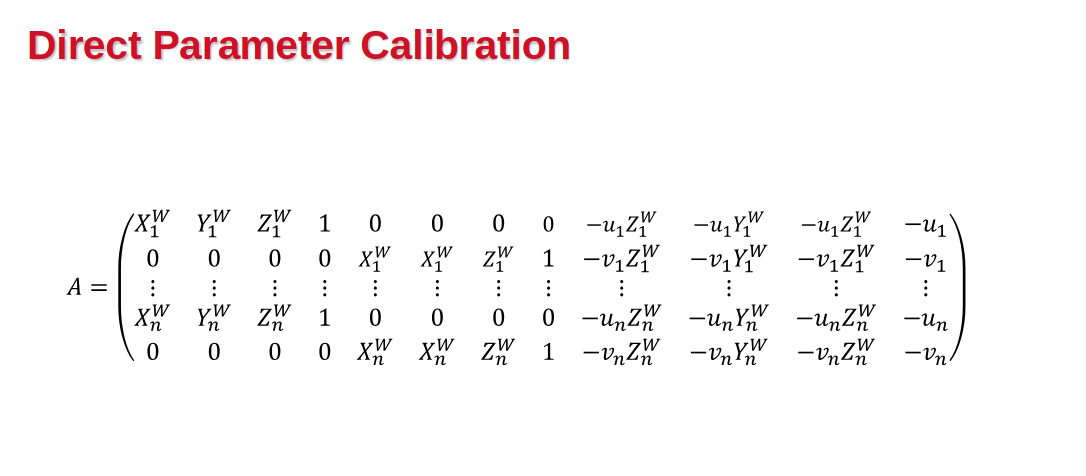)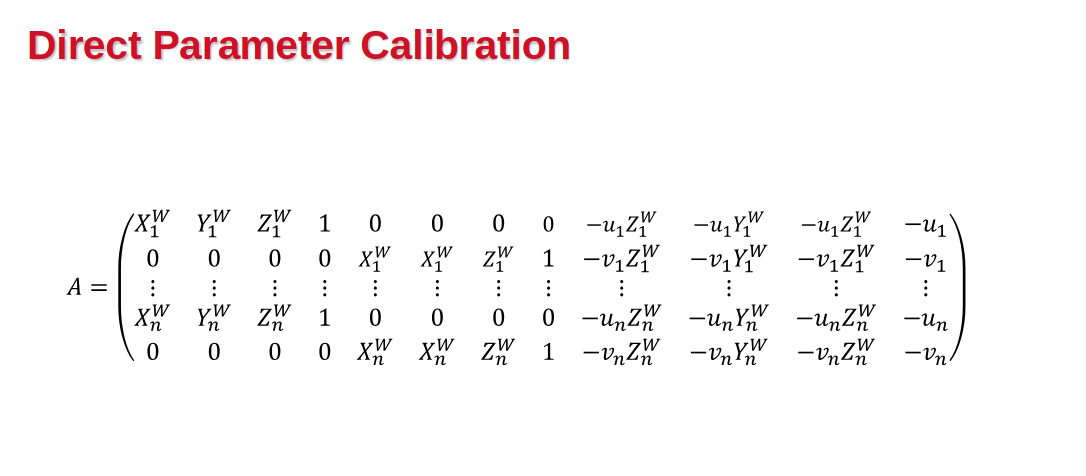

In [ ]:
num_points = len(world_points)

# Criando a matriz A completa (DLT)
A = np.zeros((2 * num_points, 12))

for idx in range(num_points):
    X, Y, Z = world_points[idx]
    u, v = i_points[idx]

    A[2 * idx] = [-X, -Y, -Z, -1, 0, 0, 0, 0, u * X, u * Y, u * Z, u]
    A[2 * idx + 1] = [0, 0, 0, 0, -X, -Y, -Z, -1, v * X, v * Y, v * Z, v]

print(A)

[[-2.650000e+01 -2.650000e+01 -0.000000e+00 -1.000000e+00  0.000000e+00
   0.000000e+00  0.000000e+00  0.000000e+00  1.788750e+04  1.788750e+04
   0.000000e+00  6.750000e+02]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 -2.650000e+01
  -2.650000e+01 -0.000000e+00 -1.000000e+00  2.202150e+04  2.202150e+04
   0.000000e+00  8.310000e+02]
 [-5.300000e+01 -1.060000e+02 -0.000000e+00 -1.000000e+00  0.000000e+00
   0.000000e+00  0.000000e+00  0.000000e+00  3.450300e+04  6.900600e+04
   0.000000e+00  6.510000e+02]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 -5.300000e+01
  -1.060000e+02 -0.000000e+00 -1.000000e+00  3.927300e+04  7.854600e+04
   0.000000e+00  7.410000e+02]
 [-1.325000e+02 -1.060000e+02 -0.000000e+00 -1.000000e+00  0.000000e+00
   0.000000e+00  0.000000e+00  0.000000e+00  1.054700e+05  8.437600e+04
   0.000000e+00  7.960000e+02]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 -1.325000e+02
  -1.060000e+02 -0.000000e+00 -1.000000e+00  9.407500

📐 6. SVD para encontrar matriz de projeção

In [ ]:
U, S, Vt = np.linalg.svd(A)
P = Vt[-1].reshape(3, 4)  # Reshape para obter matriz de projeção 3x4

print("Matriz de projeção P:")
print(P)


Matriz de projeção P:
[[-2.92837318e-03 -8.00853893e-05  7.15085590e-04 -5.93098699e-01]
 [-4.37141963e-04 -2.78173492e-04  2.76472077e-03 -8.05118676e-01]
 [-1.14425579e-06 -1.65684535e-06  1.06646002e-06 -9.19414546e-04]]


🧩 7. Decomposição RQ (K e R)

In [ ]:
# Separa a matriz M da projeção (3x3)
M = P[:, :3]

# RQ decomposition: separa K (intrínsecos) e R (rotação)
K, R = scipy.linalg.rq(M)

# Garante que os sinais na diagonal de K sejam positivos
T = np.diag(np.sign(np.diag(K)))
K = K @ T
R = T @ R
K /= K[2, 2]  # Normaliza K


📷 8. Centro da câmera


In [ ]:
# Cálculo do centro da câmera: C = -M⁻¹ * p4
p4 = P[:, 3]
C = -np.linalg.inv(M) @ p4

print("\nMatriz intrínseca K:")
print(K)

print("\nMatriz de rotação R:")
print(R)

print("\nCentro da câmera C:")
print(C)



Matriz intrínseca K:
[[1.04033846e+03 1.61407876e+01 8.17849592e+02]
 [0.00000000e+00 9.78225241e+02 7.53026074e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Matriz de rotação R:
[[-0.84352612  0.5311063  -0.07993609]
 [ 0.1904552   0.43494932  0.8800829 ]
 [-0.50218572 -0.72714867  0.46804307]]

Centro da câmera C:
[-135.81327214 -307.41005634  238.80735954]


\[
K = \begin{bmatrix}
1040.34 & 16.14 & 817.85 \\
0 & 978.23 & 753.03 \\
0 & 0 & 1
\end{bmatrix}
\]


# Resultados


\[
\begin{array}{c@{\hspace{1.5cm}}c}
\textbf{Intrinsecos : Toolbox} &
\textbf{Intrinsecos: Python} \\[1ex]
\begin{bmatrix}
1115.59 & 0 & 799.60 \\
0 & 1116.31 & 599.59 \\
0 & 0 & 1
\end{bmatrix}
&
\begin{bmatrix}
1040.34 & 16.14 & 817.85 \\
0 & 978.23 & 753.03 \\
0 & 0 & 1
\end{bmatrix}
\end{array}
\]


Embora os resultados das calibrações utilizando o método Python e o Toolbox apresentem algumas diferenças nas matrizes intrínsecas, os valores são suficientemente próximos para indicar que ambos os métodos são válidos e confiáveis para a calibração da câmera.